In [143]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from math import ceil

In [144]:
pd.set_option("max_column", 82)

In [145]:
df = pd.read_csv("train.csv")


In [146]:
class DataPreparation:

  def __init__(self,csv_path:str) -> None:
    
    self._original_df = pd.read_csv(csv_path)
    self._df = self._original_df.copy()

  @property
  def original_df(self) -> pd.DataFrame:
    return self._original_df

  @property
  def df(self) -> pd.DataFrame:
    return self._df

  @df.setter
  def df(self, value):
    self._df = value

  def pd_down_cast_numeric(self, column_name:str, _type:str):
    self.df[column_name] = pd.to_numeric(self.df[column_name], downcast=_type, errors="coerce")

  def convert_to_categorical(self,column_names: list):
    self.df[column_names] = self.df[column_names].astype("category")
    return self

  def convert_to_string(self,column_names: list):
    self.df[column_names] = self.df[column_names].astype("str")
    return self

  def convert_to_datetime(self,column_names:str, format:str):
    self.df[column_names] = pd.to_datetime(
        self.df[column_names], format=format)
    return self

  def print_unique_str_values(self):
    for col in self.df.columns.values:
      if str(self.df[col].dtypes)[:3] not in ["int", "flo"]:
        print(f"{col: <16} {self.df[col].unique()}")

  def optimize_type(self, threshold:int):
    columns_to_categorical = []
    columns_to_str = []
    for col in self.df.columns.values:
      if str(self.df[col].dtypes).__contains__("object"):
        if self.df[col].unique().__len__() < threshold :
          columns_to_categorical.append(col)
        else:
          columns_to_str.append(col)
      elif str(self.df[col].dtypes).__contains__("int"):
        self.pd_down_cast_numeric(col,"integer")
      elif str(self.df[col].dtypes).__contains__("float"):
        self.pd_down_cast_numeric(col,"float")
        
    self.convert_to_categorical(columns_to_categorical)
    self.convert_to_string(columns_to_str)

    return self

  def nan_unique_info(self,head:int):
    a, b, c, d = [], [], [], []
    for col in self.df.columns.values:
        total_na = self.df[col].isnull().sum()
        #print(f"{col: <16} {total_na: <16}  {per: <16} {len(df[col].unique()): <16}")
        a.append(col)
        b.append(total_na)
        c.append(round((total_na/len(self.df[col]))*100, 2))
        d.append(len(self.df[col].unique()))

    return pd.DataFrame({"Columns": a, "No_of_null": b, "% of null": c,
                        "No_of_unique_value": d}).sort_values(["No_of_null", "No_of_unique_value"], ascending=False, ignore_index=True).head(head)

  def print_unique_val(self, col_names:list):
    for col_name in col_names:
      print(f"{col_name: <16} {self.df[col_name].unique()}")

  def corr_list(self,target_col:str, threshold:int):
    corr = self.df.corr()
    return corr[corr[target_col].abs() > threshold].drop(target_col)[target_col].sort_values(ascending=False)

  def plot_scatter(self, x_col:str, y_col:str, show_appr=True, degrees=[1]):
    def interp(x,coefs,deg):
      length = len(range(deg))
      return sum([(coefs[i]*pow(x, length - i)) for i in range(deg)])+coefs[length]

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=self.df[x_col], y=self.df[y_col], mode="markers", showlegend=False)
    )

    if show_appr :
      df = self.df[[x_col, y_col]].sort_values(x_col).copy()
      for deg in degrees:
        coefs = np.polyfit(df[x_col], df[y_col], deg)
        fig.add_trace(
            go.Scatter(x=df[x_col], y=interp(
                df[x_col].sort_values(), coefs,deg), mode="lines", name=f"Approximation degree {deg}")
        )

    fig.update_layout(title_text=f"{x_col} against {y_col} plot",title_x=0.5)
    fig.update_xaxes(title_text=f"{x_col}")
    fig.update_yaxes(title_text=f"{y_col}")

    return fig

  def plot_box(self, x_col:str, y_col:str):
    fig = go.Figure()
    fig.add_trace(
      go.Box(x=self.df[x_col], y=self.df[y_col] )
    )

    fig.update_layout(title_text=f"{x_col} against {y_col} plot",title_x=0.5)
    fig.update_xaxes(title_text=f"{x_col}")
    fig.update_yaxes(title_text=f"{y_col}")

    return fig

  def plot_sub_scatters(self, col_names: list, target_col: str, height=600, width=600):

    rows = ceil(len(col_names)/2)
    titles = [f"{x_col} against {target_col} plot" for x_col in col_names]
    fig = make_subplots(rows=rows, cols=2, subplot_titles=titles) 

    row = 0
    for i, x_col in enumerate(col_names):
      col = 1 
      if i%2==0: 
        row += 1
      else:
        col = 2
      fig.add_trace(
          go.Scatter(x=self.df[x_col], y=self.df[target_col],
                     mode="markers", showlegend=False),
          row=row,
          col=col 
      )
      fig.update_xaxes(title_text=f"{x_col}", row=row, col=col)
      fig.update_yaxes(title_text=f"{target_col}", row=row, col=col)
      fig.update_layout(height=height, width=width)

    return fig

  def drop(self, indexes=[], columns=[]):
    self.df.drop(indexes, errors="ignore", inplace=True)
    self.df.drop(columns, axis=1 ,errors="ignore", inplace=True)
    return self

  def unnecessary_categories(self, prop_val=0.01):
    columns = self.df.select_dtypes("category").columns.values
    for col in columns:
        values = self.df[col].value_counts(True,dropna=False)
        prop = 1/len(values.values)
        x_prop = prop*prop_val
        
        count = 0
        for val in values.values:
            if val < x_prop :
                count+=1
        if count == len(values.values)-1:
            print(f"Column name :         {col:30s} ")
            print(values)

  def _nan_info(self, threshold:int):
    count_ = self.df.isnull().sum()
    df_na = pd.DataFrame({"label": count_.index, "n_values": count_.values})
    df_na.drop(df_na[df_na.n_values == 0].index, inplace= True)
    df_na["perc_na"] = df_na["n_values"].apply(lambda x: (x/len(df))*100)
    df_na["color"] = df_na["perc_na"].apply(lambda x: "blue" if x < threshold else "red")

    return df_na

  def highest_nan_columns(self, threshold:int):
    df_na =  self._nan_info(threshold)
    return df_na[df_na["perc_na"] > threshold].label.values

  def plot_nan_percentage(self, threshold:int):
    df_na = self._nan_info(threshold)
    n = len(df_na[df_na["perc_na"] > threshold].index)
    fig = px.bar(data_frame=df_na, y="perc_na", x="label", color_discrete_map=dict(zip(df_na.label, df_na.color)), color="label", )
    fig.add_hline(y=threshold,line_color="green",)
    fig.update_layout(
        title=f"There  are {n} columns over {threshold}% elements null ", title_x=0.5, showlegend=False)
    fig.show()

  def numeric_df(self):
    return self.df[[col for col in self.df.columns.values if str(
        self.df[col].dtypes)[:3] in ["int", "flo"]]].copy()

  def category_df(self):
    return self.df.select_dtypes("category").copy()

  def numeric_corr(self, target_col:str, col_to_drop=[], corr_thresh=0.4):
    corr = self.numeric_df().drop(col_to_drop, axis=1, errors="ignore").corr()
    return corr[corr[target_col].abs() > 0.4].drop(target_col, errors="ignore")[target_col]


# Data loading

In [147]:
dp = DataPreparation("train.csv")

# Data Exploration

In [148]:
dp.df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [149]:
dp.df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- there are : 
    - 81 columns
    - 1460 rows
    - 3 types of data (float, int and object)
    - missing data in some columns like Alley

## optimize dataframe

In [150]:
dp.optimize_type(30).df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int16   
 1   MSSubClass     1460 non-null   int16   
 2   MSZoning       1460 non-null   category
 3   LotFrontage    1201 non-null   float32 
 4   LotArea        1460 non-null   int32   
 5   Street         1460 non-null   category
 6   Alley          91 non-null     category
 7   LotShape       1460 non-null   category
 8   LandContour    1460 non-null   category
 9   Utilities      1460 non-null   category
 10  LotConfig      1460 non-null   category
 11  LandSlope      1460 non-null   category
 12  Neighborhood   1460 non-null   category
 13  Condition1     1460 non-null   category
 14  Condition2     1460 non-null   category
 15  BldgType       1460 non-null   category
 16  HouseStyle     1460 non-null   category
 17  OverallQual    1460 non-null   in

In [151]:
df = dp.df

## Null values

In [152]:
nu = dp.nan_unique_info(30)
nu

,Columns,No_of_null,% of null,No_of_unique_value
0,PoolQC,1453,99.52,4
1,MiscFeature,1406,96.30,5
2,Alley,1369,93.77,3
3,Fence,1179,80.75,5
4,FireplaceQu,690,47.26,6
5,LotFrontage,259,17.74,111
6,GarageYrBlt,81,5.55,98
7,GarageType,81,5.55,7
8,GarageQual,81,5.55,6
9,GarageCond,81,5.55,6


- Let's look at the 3 first rows

In [153]:
dp.print_unique_val(["PoolQC", "MiscFeature", "Alley"])

PoolQC           [NaN, 'Ex', 'Fa', 'Gd']
Categories (3, object): ['Ex', 'Fa', 'Gd']
MiscFeature      [NaN, 'Shed', 'Gar2', 'Othr', 'TenC']
Categories (4, object): ['Shed', 'Gar2', 'Othr', 'TenC']
Alley            [NaN, 'Grvl', 'Pave']
Categories (2, object): ['Grvl', 'Pave']


- We can notice that NaN for means these features are not available for that house.
- It's more the 90% for each of them. That doesn't our any information.
- So these features can be deleted:

In [154]:
columns_to_drop = nu.Columns[:3].values
columns_to_drop

array(['PoolQC', 'MiscFeature', 'Alley'], dtype=object)

## Correlation

In [155]:
corr_list = dp.corr_list("SalePrice",0.5)

fig = px.bar(corr_list,)
fig.update_layout(title="columns correlated with target", title_x=0.5, )
fig.show()

- We can notice that these features have the highest correlation with SalePrice

## Target variable

In [156]:
dp.df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

- We can notice a huge hole between the min, mean and max value. 

In [157]:
px.box(dp.df, y="SalePrice",)

- Box plot confirme that there are outliers in SalePrice
- Due to the high deference between prices, we can apply log to tackle that

In [158]:
px.box(y=np.log(dp.df.SalePrice))

In [159]:
dp.plot_scatter("YearBuilt", "SalePrice", degrees=[1, 2])


- We can see that SalePrice decreased and reached its minimun at around 1932
than started increasing probably due to the inflation or the buiding of new type of modern houses
- Let's add a new variable to highlight how long remodeling has been doing

In [160]:
dp.df["YearsAfterRemodel"] = dp.df.YearRemodAdd - dp.df.YearBuilt 

In [161]:
dp.plot_scatter("YearBuilt", "YearsAfterRemodel", False)


In [162]:
dp.plot_scatter("YearsAfterRemodel", "SalePrice", degrees=[1])


- We can see that must of houses has been remodeled 40 years ego with correspond to the range of increasing SalePrice.
- Also SalePrice decrease with old houses not remodeled.


## SalePrice and Neighborhood

In [163]:
dp.plot_box("Neighborhood", "SalePrice")


- neighborhoods (NoRidge, NrigHt and StoneBr ) have the highest SalePrice
- neighborhoods (BrDale and MeadowV ) have the lowest SalePrice
- How can we explain that?

In [164]:
px.histogram(dp.df, x="Neighborhood", y="SalePrice",
             color="Foundation",)


- Most of houses having Poured Contrete foundation has SalePrice median over than 200k
- On other side, houses having Cinder Block foundation has small SalePrice median

- We can conclude that foundation is a key facteur in house price

## SalePrice and MsZones

In [165]:
dp.plot_box("MSZoning", "SalePrice")


- Floating Village Residential and Residential Low Density have higher price than commercial zones

In [166]:
px.histogram(dp.df, x="MSZoning", y="SalePrice",
             color="Foundation", barmode="group")


- We can also notice that PConc foundation dominates in 2 types of zone 

In [167]:
dp.plot_sub_scatters(
    corr_list.index, "SalePrice",height=1500, width=900)


## Other plots

In [168]:
columns = dp.df.select_dtypes("category").columns.values

In [169]:
columns_names, categories, count = [], [], []
for col in columns:
    s = dp.df[col].value_counts()
    count.extend(s.values)
    categories.extend(s.index)
    columns_names.extend([col]*s.size)


In [170]:
df = pd.DataFrame({"columns_names":columns_names, "categories":categories, "count":count})


In [171]:
fig = px.sunburst(df, path=['columns_names', 'categories',],
                  values='count', color='categories')
fig.update_layout(height=800, width=800)
fig.show()


# Data Cleanning

In [172]:
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley']

## Outliers

In [173]:
a = dp.df.query("GrLivArea > 4000 & SalePrice < 300000").index.values
b = dp.df.query("((GarageArea > 1200) & (SalePrice < 300000) )|((GarageArea > 600 )&(SalePrice > 600000)) ").index.values
c = dp.df.query("TotalBsmtSF > 4000 & SalePrice < 200000").index.values
d = dp.df[(dp.df["SalePrice"] < 200000) & (dp.df["1stFlrSF"] > 4000)].index.values
e = dp.df.query("EnclosedPorch > 400 ").index.values
f = dp.df.query("SalePrice > 700000 ").index.values

indexes = np.append(a,b)
indexes = np.append(indexes,c)
indexes = np.append(indexes,d)
indexes = np.append(indexes,e)
indexes = np.append(indexes,f)
indexes = np.unique(indexes).tolist()
indexes


[197, 523, 581, 691, 898, 1061, 1169, 1182, 1190, 1298]

In [174]:
dp.drop(indexes=indexes).plot_sub_scatters(
    ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "EnclosedPorch"], "SalePrice", height=1200, width=900)


## Drop Unnecessary Columns

In [175]:
dp.unnecessary_categories()


Column name :         Street                         
Pave    0.996552
Grvl    0.003448
Name: Street, dtype: float64
Column name :         Utilities                      
AllPub    0.99931
NoSeWa    0.00069
Name: Utilities, dtype: float64
Column name :         PoolQC                         
NaN    0.997241
Gd     0.001379
Fa     0.001379
Ex     0.000000
Name: PoolQC, dtype: float64


In [176]:
columns_to_drop.extend(["Utilities", "Street","Id"])
columns_to_drop = list(set(columns_to_drop))
columns_to_drop


['Street', 'Alley', 'PoolQC', 'Utilities', 'MiscFeature', 'Id']

In [177]:
dp.drop(columns=columns_to_drop).df.head(5)


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YearsAfterRemodel
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,0,2,2008,WD,Normal,208500,0
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,0,5,2007,WD,Normal,181500,0
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,0,9,2008,WD,Normal,223500,1
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,0,2,2006,WD,Abnorml,140000,55
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,0,12,2008,WD,Normal,250000,0


## Fill NaN

In [178]:
cat_cols = dp.df.select_dtypes("category").columns
dp.df[cat_cols] = dp.df[cat_cols].astype("string").fillna("None").astype("category")

other_cols = dp.df.select_dtypes(exclude="category").columns
dp.df[other_cols] = dp.df[other_cols].fillna(0)


- We replaced all None by No for category and 0 for numerical

In [179]:
dp.df.isnull().sum().sum()

0

- No more NaN values

# Data Preparation

In [180]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

## Feature engineering

In [181]:
def pipeline_preparation(file_name:str, train=False, encoders={}):
    index_to_drop = [197, 523, 581, 691, 898, 1061, 1169, 1182, 1190, 1298]
    col_to_drop = ['MiscFeature', 'Alley', 'Street', 'PoolQC', 'Utilities']

    dp = DataPreparation(file_name).convert_to_categorical(
    ["OverallQual", "OverallCond", "MSSubClass"]).drop(columns=col_to_drop).optimize_type(30)

    if train:
        dp.drop(indexes=index_to_drop)
        dp.drop(columns=['Id'])
        dp.df.SalePrice = dp.df.SalePrice.apply("log")
    
    cat_cols = dp.df.select_dtypes("category").columns
    other_cols = dp.df.select_dtypes(exclude="category").columns


    dp.df[cat_cols] = dp.df[cat_cols].astype("string").fillna("None").astype("category")
    dp.df[other_cols] = dp.df[other_cols].fillna(0)

    if len(encoders.values()) == 0:
        encoders = {col: LabelEncoder() for col in dp.df[cat_cols].columns.values}
    #dp.df[cat_cols] = dp.df[cat_cols].apply(lambda x: encoders[x.name].fit_transform(x))

    dp.df['Total_SF'] = dp.df['TotalBsmtSF'] + dp.df['1stFlrSF'] + dp.df['2ndFlrSF']

    dp.df['Total_Bathrooms'] = (dp.df['FullBath'] + (0.5 * dp.df['HalfBath']) + dp.df['BsmtFullBath'] 
                             + (0.5 * dp.df['BsmtHalfBath']))

    dp.df['Total_Porch_SF'] = (dp.df['OpenPorchSF'] + dp.df['3SsnPorch'] + dp.df['EnclosedPorch'] + 
                            dp.df['ScreenPorch'] + dp.df['WoodDeckSF'])

    dp.df['Total_Square_Feet'] = (dp.df['BsmtFinSF1'] + dp.df['BsmtFinSF2'] + dp.df['1stFlrSF'] + dp.df['2ndFlrSF'])

    dp.df['Total_Quality'] = dp.df['OverallQual'].astype("int8") + dp.df['OverallCond'].astype("int8")

    dp.df["YearsAfterRemodel"] = dp.df.YearRemodAdd - dp.df.YearBuilt

    dp.df["Remodel"] = dp.df["YearsAfterRemodel"].apply(lambda x: 0 if x==0 else 1)

    dp.df["NewGarage"] = dp.df.GarageArea * dp.df.GarageCars
    # if train:
    #     dp.df = pd.get_dummies(dp.df)
    # else:
    #     dp.df = pd.get_dummies(dp.df,columns=dp.df.columns.difference(["Id"]))

    # id_ = dp.df.Id
    # dp.drop(columns=["Id"])

    dp.df = pd.get_dummies(dp.df)
    #
    #  dp.df["Id"] = id_
    
    return dp.df, encoders


## Split

In [182]:
df_train, train_encoders = pipeline_preparation("train.csv", True)

In [183]:
features, target = df_train[df_train.columns.difference(["SalePrice"])].to_numpy(), df_train.SalePrice.to_numpy()

In [184]:
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=21,shuffle=True)

# Training

In [185]:
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor,StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn import metrics
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint as pp


## First training

In [186]:
estimators = [
     ('lr', RidgeCV()),
     ('svr', Pipeline([('scaler', StandardScaler()), ('svc', SVR())]))
]

models = {"GradientBoostingRegressor":GradientBoostingRegressor(),
        "BaggingRegressor":BaggingRegressor(),
        "StackingRegressor": StackingRegressor(estimators, final_estimator=GradientBoostingRegressor()),
        "XGBRegressor":XGBRegressor(),
}



def rmse(y_pred, y_train):
    return np.sqrt(metrics.mean_squared_error(y_pred, y_train))

def train_modes(models:dict, x_train, y_train, x_val, y_val):
    res = {}
    for name, model in models.items():
        model = model.fit(x_train, y_train)

        y_pred = model.predict(x_val)

        res[name] = {
                "Rmse":rmse(y_pred, y_val),
                "Score_train": model.score(x_train, y_train),
                "Score_val": model.score(x_val, y_val),
            }

    return res


In [12]:
res = train_modes(models, x_train, y_train, x_val, y_val)
pp(res,)


{'BaggingRegressor': {'Rmse': 0.1446564745092365,
                      'Score_train': 0.9763794017341983,
                      'Score_val': 0.8589219246661608},
 'GradientBoostingRegressor': {'Rmse': 0.11633903535449076,
                               'Score_train': 0.9641617083585061,
                               'Score_val': 0.9087496182436262},
 'StackingRegressor': {'Rmse': 0.13454122537001792,
                       'Score_train': 0.9250611719548989,
                       'Score_val': 0.8779621547968688},
 'XGBRegressor': {'Rmse': 0.12988398958396558,
                  'Score_train': 0.9996880817774276,
                  'Score_val': 0.8862647691350084}}


## Fine tune Hyperparameters

In [93]:
xg = XGBRegressor(base_score=0, subsample=0.5, learning_rate=0.05, max_delta_step=50,gamma=0.001, min_child_weight=5 ,n_estimators=5000,validate_parameters=True ,eval_metric="rmse" ,early_stopping_rounds=5 )

In [102]:
xg.fit(x_train, y_train, eval_set=[(x_val, y_val)],  verbose=False)
y_pred = xg.predict(x_val)
print(f"Rmse: {rmse(y_pred, y_val)}",
      f"Score_train: {xg.score(x_train, y_train)}",
      f"Score_val: {xg.score(x_val, y_val)}",sep="\n"
      )


Rmse: 0.11227373885873067
Score_train: 0.9728283762953746
Score_val: 0.918745055412374


In [166]:
gb = GradientBoostingRegressor(learning_rate=.01,n_estimators=5000,subsample=.5,max_depth=3,alpha=.7,max_leaf_nodes=100)

In [167]:
gb.fit(x_train, y_train)
y_pred = gb.predict(x_val)
print(f"Rmse: {rmse(y_pred, y_val)}",
      f"Score_train: {gb.score(x_train, y_train)}",
      f"Score_val: {gb.score(x_val, y_val)}",sep="\n"
    )

Rmse: 0.11135888347824177
Score_train: 0.9951832672909341
Score_val: 0.9163947578724653


In [163]:
imp_df = pd.DataFrame(
    {"columns": df_train.columns.difference(["SalePrice"]), "importance": xg.feature_importances_})
px.bar(imp_df[imp_df.importance > 0.001], x="columns", y="importance")


# Testing

In [216]:

df_test, _ = pipeline_preparation("test.csv", encoders=train_encoders)
x_test = df_test[df_test.columns.difference(["Id"])].to_numpy()


In [222]:
y_final_pred = xg.predict(x_test)
predictions = np.expm1(y_final_pred)
print(predictions)

[129511.05 160697.72 183953.23 ... 144031.64 120738.46 224496.95]


In [221]:
submit = pd.DataFrame({"Id":df_test.Id,"SalePrice":predictions})
submit.to_csv('submission_gb.csv',index=False)

In [219]:
submit

,Id,SalePrice
0,1461,129511.046875
1,1462,160697.718750
2,1463,183953.234375
3,1464,184765.515625
4,1465,186076.015625
...,...,...
1454,2915,84301.023438
1455,2916,77573.507812
1456,2917,144031.640625
1457,2918,120738.460938


# Deep Learning model

In [125]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
import tensorboard
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import matplotlib.pyplot as plt

In [108]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [110]:
logs_dir = "C:/Users/tabou/Desktop/pro/kaggle_data_analysis/house-prices-advanced-regression-techniques/logs"

In [126]:
%tensorboard --logdir logs_dir


Reusing TensorBoard on port 6006 (pid 22772), started 0:15:38 ago. (Use '!kill 22772' to kill it.)

In [187]:
normalizer = layers.Normalization()

In [188]:
normalizer.adapt(np.array(x_train))

In [189]:
FEATURES = x_train.shape[1]

In [190]:
model = keras.Sequential([
    normalizer,
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)             
])


In [191]:
model.compile(
    loss=keras.losses.MeanSquaredError(), 
    optimizer=keras.optimizers.Adam(), 
    metrics=[keras.metrics.MeanSquaredError()],
)

In [192]:
histories = {}

In [193]:
histories["deep"] = model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val), callbacks=[keras.callbacks.TensorBoard(
    logs_dir), keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=20), ])


Epoch 1/200
37/37 [==============================] - 3s 33ms/step - loss: 29.1930 - mean_squared_error: 27.2606 - val_loss: 29630533632.0000 - val_mean_squared_error: 29630533632.0000
Epoch 2/200
37/37 [==============================] - 1s 25ms/step - loss: 10.1954 - mean_squared_error: 8.2477 - val_loss: 2357957376.0000 - val_mean_squared_error: 2357957376.0000
Epoch 3/200
37/37 [==============================] - 1s 24ms/step - loss: 8.4757 - mean_squared_error: 6.5227 - val_loss: 149972240.0000 - val_mean_squared_error: 149972240.0000
Epoch 4/200
37/37 [==============================] - 1s 22ms/step - loss: 7.8505 - mean_squared_error: 5.8946 - val_loss: 6632937.5000 - val_mean_squared_error: 6632935.5000
Epoch 5/200
37/37 [==============================] - 1s 24ms/step - loss: 7.1786 - mean_squared_error: 5.2210 - val_loss: 111168.3906 - val_mean_squared_error: 111166.4297
Epoch 6/200
37/37 [==============================] - 1s 22ms/step - loss: 7.0659 - mean_squared_error: 5.1069 -

In [194]:
y_pred = model.predict(x_val)
print(f"Rmse: {rmse(y_pred, y_val)}",
      f"Score_train: {model.evaluate(x_train, y_train)}",
      f"Score_val: {model.evaluate(x_val, y_val)}",sep="\n"
    )

10/10 [==============================] - 0s 6ms/step - loss: 0.3307 - mean_squared_error: 0.0474
Rmse: 0.21764960314678677
Score_train: [0.32669901847839355, 0.04335251823067665]
Score_val: [0.33071786165237427, 0.047371335327625275]


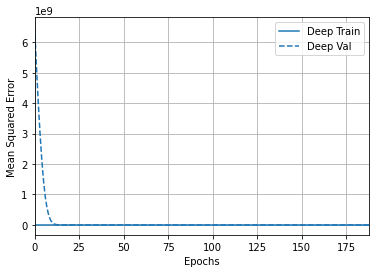

In [195]:
plotter = tfdocs.plots.HistoryPlotter(
    metric='mean_squared_error', smoothing_std=10)
plotter.plot(histories)
#plt.ylim([0.5, 0.7])
